### I believe in the efficient market hypothesis. Index funds can and will beat your portfolios most of the time. We can't really predict Stock Prices. So this is just a coding exercise.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from textblob import TextBlob
import tweepy

from fbprophet import Prophet

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
consumer_key = "SnTNuIWo5l04U113ctQpsTBjb"
consumer_secret = "kz0loqLUNqf667MUEsaIFWqUH34aQCs1AGjUKyw7LnpiN9tqDf"

assess_token = "2347769886-U6gqkm0IOW1f1jkHBq1tPGBDQRXnHMYj0Oce3Ax"
assess_token_secret = "wTrSIjrEvfPFIwUQMBLevT2wVpD31nfqYSDvLtFCIj9HZ"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(assess_token,assess_token_secret)

api = tweepy.API(auth)

In [3]:
# Search the stock in twitter, take an input from the user
# Count the percentage of positive, say 50% positive will triger our model; otherwise, loop back to last step.
def stock():
    t = True
    while t == True:
        q = str(input('Company name: ')  + ' Stock')
        public_tweets = api.search(q=q,lang="en",count = 100 )
        i = 0
        for tweet in public_tweets:
            anaylsis = TextBlob(tweet.text)
            if anaylsis.sentiment.polarity > 0:
                i+=1
        print(i)
        if i/100 > 0.5:
            print ("Good vibe, let's do it")
            t = False
        else:
            print ("The company is not doing well today. Pick another one.")
            t = True
    return q
q = stock()

Company name: Google


INFO:tweepy.binder:PARAMS: {'q': b'Google Stock', 'lang': b'en', 'count': b'100'}


26
The company is not doing well today. Pick another one.
Company name: Apple


INFO:tweepy.binder:PARAMS: {'q': b'Apple Stock', 'lang': b'en', 'count': b'100'}


70
Good vibe, let's do it


In [4]:
# Build a stock dictionary. Ideally it should include all.
d = dict()
d['Apple Stock'] = 'AAPL'
d['Google Stock'] = 'GOOGL'
d['Amazon Stock'] = 'AMZN'
d['TESLA Stock'] = 'TSLA'
d['Facebook Stock'] = 'FB'
d['Sony Stock'] = 'SNE'
d['Microsoft Stock'] = 'MSFT'

In [5]:
stockname = d[q]

### Grab last 5 years' stock

In [6]:
end = datetime.date.today()
start = end - datetime.timedelta(days=380*5)

### Prefer yahoo, has adjust close price. Google finance doesn't have adj close. Adj close accounts for corporate actions

In [7]:
# Yahoo will fail from time to time
df = web.DataReader(stockname,'yahoo',start,end)

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-29,81.557144,82.000000,80.758568,81.752853,73.549454,95127200
2012-05-30,81.314285,82.855713,80.937141,82.738571,74.436249,132357400
2012-05-31,82.962860,83.071426,81.637146,82.532860,74.251175,122918600
2012-06-01,81.308571,81.807144,80.074287,80.141426,72.099739,130246900
2012-06-04,80.214287,81.071426,78.357140,80.612854,72.523842,139248900


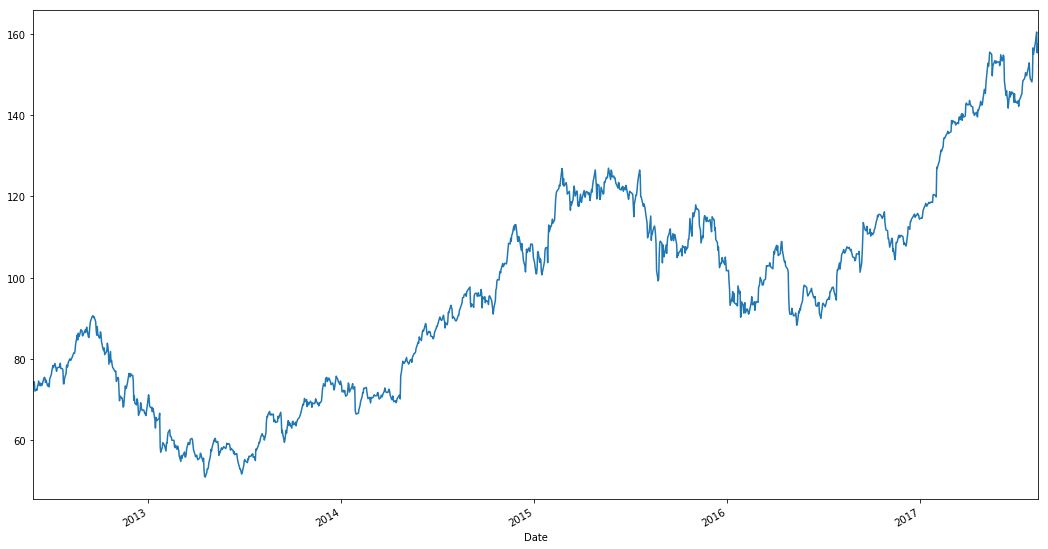

In [9]:
df['Adj Close'].plot()

### Candlestick plotting, credit to CURTIS MILLER https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/

In [10]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", 
    likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs 
    include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days 
    included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to 
    be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

### Black - gain; red - loss

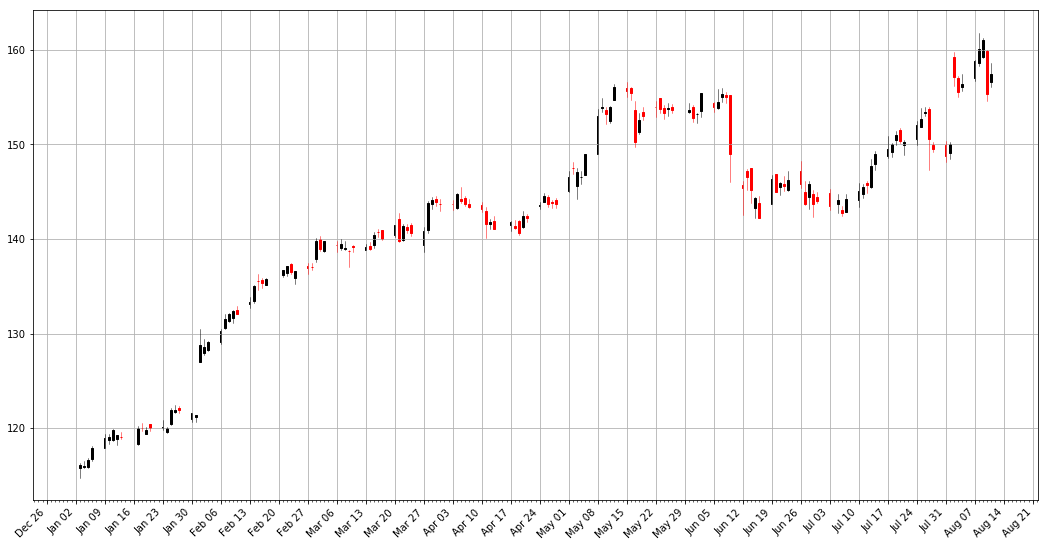

In [11]:
pandas_candlestick_ohlc(df.loc['2017-01-01':,:])

In [12]:
# log the adj close
df['log_adj_close'] = np.log(df['Adj Close'])
df.head()

,Open,High,Low,Close,Adj Close,Volume,log_adj_close
Date,,,,,,,
2012-05-29,81.557144,82.000000,80.758568,81.752853,73.549454,95127200,4.297958
2012-05-30,81.314285,82.855713,80.937141,82.738571,74.436249,132357400,4.309943
2012-05-31,82.962860,83.071426,81.637146,82.532860,74.251175,122918600,4.307454
2012-06-01,81.308571,81.807144,80.074287,80.141426,72.099739,130246900,4.278050
2012-06-04,80.214287,81.071426,78.357140,80.612854,72.523842,139248900,4.283915


In [13]:
df_final = df[['Close','Adj Close','log_adj_close']]

In [14]:
df_final.head()

,Close,Adj Close,log_adj_close
Date,,,
2012-05-29,81.752853,73.549454,4.297958
2012-05-30,82.738571,74.436249,4.309943
2012-05-31,82.532860,74.251175,4.307454
2012-06-01,80.141426,72.099739,4.278050
2012-06-04,80.612854,72.523842,4.283915


# Model No.1 Prophet Module

Developed by Facebook for forecasting time series data. 

In [15]:
df_prophet=df.copy()
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet[['Date','log_adj_close']]
df_prophet.head()

,Date,log_adj_close
0,2012-05-29,4.297958
1,2012-05-30,4.309943
2,2012-05-31,4.307454
3,2012-06-01,4.278050
4,2012-06-04,4.283915


In [16]:
df_prophet = df_prophet.rename(columns={'Date':'ds','log_adj_close':'y'})

In [17]:
m = Prophet(growth='logistic')
df_prophet['cap'] = 7
m.fit(df_prophet)
future=m.make_future_dataframe(periods=2000)
future['cap']=7
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3306,2023-01-28,3.821438,-0.787133,4.730643
3307,2023-01-29,3.823022,-0.791519,4.729184
3308,2023-01-30,6.860596,2.221980,7.763697
3309,2023-01-31,6.862517,2.207825,7.761219
3310,2023-02-01,6.865002,2.192153,7.768607


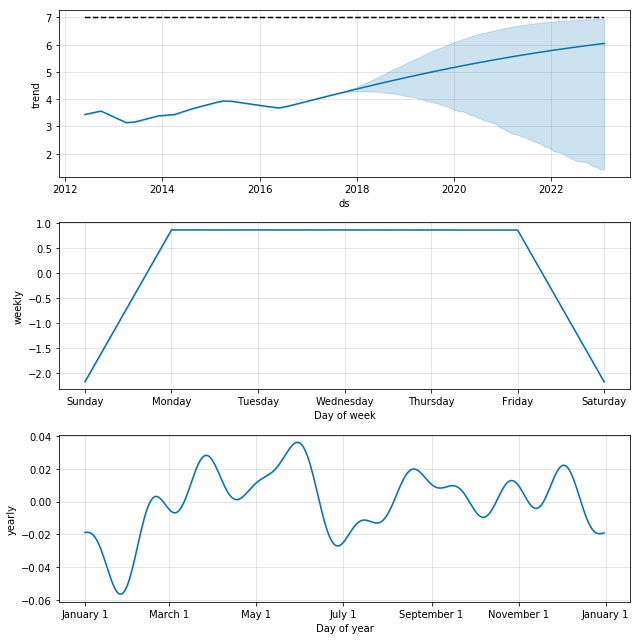

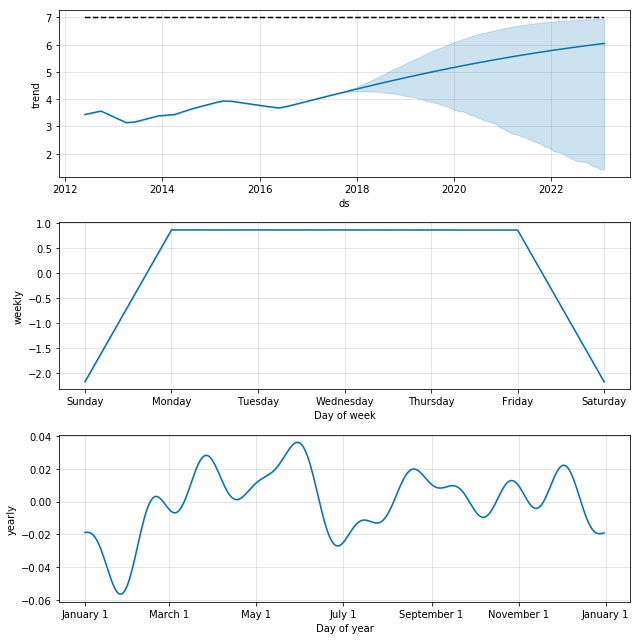

In [18]:
m.plot_components(forecast)

# Model No.2 Keras Neural Network, credit to Jason Brownlee
http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [19]:
numpy.random.seed(7)

In [20]:
df_keras = df.copy()
df_keras.head()

,Open,High,Low,Close,Adj Close,Volume,log_adj_close
Date,,,,,,,
2012-05-29,81.557144,82.000000,80.758568,81.752853,73.549454,95127200,4.297958
2012-05-30,81.314285,82.855713,80.937141,82.738571,74.436249,132357400,4.309943
2012-05-31,82.962860,83.071426,81.637146,82.532860,74.251175,122918600,4.307454
2012-06-01,81.308571,81.807144,80.074287,80.141426,72.099739,130246900,4.278050
2012-06-04,80.214287,81.071426,78.357140,80.612854,72.523842,139248900,4.283915


In [21]:
df_keras.reset_index(inplace=True)

In [22]:
df_keras = df_keras.loc[:,'Adj Close']

In [23]:
df_keras = df_keras.values
df_keras = df_keras.astype('float32')
df_keras = df_keras.reshape(len(df_keras),1)

In [24]:
df_keras

array([[  73.54945374],
       [  74.43624878],
       [  74.25117493],
       ..., 
       [ 160.42999268],
       [ 155.32000732],
       [ 157.47999573]], dtype=float32)

In [25]:
train_size = int(len(df_keras) * 0.75)
test_size = len(df_keras) - train_size
train, test = df_keras[0:train_size,:], df_keras[train_size:len(df_keras),:]
len(train), len(test)

(983, 328)

In [26]:
# Create datamatrix, use five look_back.
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return numpy.array(dataX), numpy.array(dataY)

In [27]:
look_back = 5
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)

In [28]:
# lose 10 cases, 5 for train, 5 for test, because look_back = 5
df_keras.shape, trainX.shape, testX.shape

((1311, 1), (978, 5), (323, 5))

In [29]:
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
0s - loss: 82.2896
Epoch 2/400
0s - loss: 4.3352
Epoch 3/400
0s - loss: 4.0690
Epoch 4/400
0s - loss: 3.9380
Epoch 5/400
0s - loss: 4.3173
Epoch 6/400
0s - loss: 3.5416
Epoch 7/400
0s - loss: 2.9227
Epoch 8/400
0s - loss: 3.1682
Epoch 9/400
0s - loss: 2.9907
Epoch 10/400
0s - loss: 2.8887
Epoch 11/400
0s - loss: 3.0257
Epoch 12/400
0s - loss: 2.9563
Epoch 13/400
0s - loss: 3.3990
Epoch 14/400
0s - loss: 2.8251
Epoch 15/400
0s - loss: 2.9595
Epoch 16/400
0s - loss: 3.2456
Epoch 17/400
0s - loss: 2.6961
Epoch 18/400
0s - loss: 2.7013
Epoch 19/400
0s - loss: 2.9013
Epoch 20/400
0s - loss: 3.1451
Epoch 21/400
0s - loss: 2.7798
Epoch 22/400
0s - loss: 2.9705
Epoch 23/400
0s - loss: 2.9275
Epoch 24/400
0s - loss: 3.0423
Epoch 25/400
0s - loss: 2.9790
Epoch 26/400
0s - loss: 2.8946
Epoch 27/400
0s - loss: 3.0400
Epoch 28/400
0s - loss: 3.0804
Epoch 29/400
0s - loss: 2.9583
Epoch 30/400
0s - loss: 3.0001
Epoch 31/400
0s - loss: 2.7822
Epoch 32/400
0s - loss: 2.9277
Epoch 33/400
0s 

0s - loss: 2.5868
Epoch 261/400
0s - loss: 2.4873
Epoch 262/400
0s - loss: 2.5353
Epoch 263/400
0s - loss: 2.6351
Epoch 264/400
0s - loss: 2.8082
Epoch 265/400
0s - loss: 2.4444
Epoch 266/400
0s - loss: 2.5193
Epoch 267/400
0s - loss: 2.4839
Epoch 268/400
0s - loss: 2.4003
Epoch 269/400
0s - loss: 2.4274
Epoch 270/400
0s - loss: 2.6345
Epoch 271/400
0s - loss: 2.6537
Epoch 272/400
0s - loss: 2.4743
Epoch 273/400
0s - loss: 2.4884
Epoch 274/400
0s - loss: 2.6070
Epoch 275/400
0s - loss: 2.6133
Epoch 276/400
0s - loss: 2.4969
Epoch 277/400
0s - loss: 2.4205
Epoch 278/400
0s - loss: 2.5967
Epoch 279/400
0s - loss: 2.5350
Epoch 280/400
0s - loss: 2.6607
Epoch 281/400
0s - loss: 2.3874
Epoch 282/400
0s - loss: 2.6807
Epoch 283/400
0s - loss: 2.4831
Epoch 284/400
0s - loss: 2.5307
Epoch 285/400
0s - loss: 2.6351
Epoch 286/400
0s - loss: 2.3731
Epoch 287/400
0s - loss: 2.5370
Epoch 288/400
0s - loss: 2.5831
Epoch 289/400
0s - loss: 2.6502
Epoch 290/400
0s - loss: 2.5149
Epoch 291/400
0s - los

In [30]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX, testY, verbose=0)

In [31]:
trainScore, testScore

(2.1507185548848655, 2.4143790992051826)

In [32]:
trainPred = model.predict(trainX)
testPred = model.predict(testX)

In [33]:
# Shift for ploting, start from look_back point
trainPred_shift = numpy.empty_like(df_keras)
trainPred_shift[:, :] = numpy.nan
trainPred_shift[look_back:len(trainPred)+look_back,:] = trainPred

In [34]:
# Shift for ploting, end the number of "look_back" short of the data length
testPred_shift = numpy.empty_like(df_keras)
testPred_shift[:, :] = numpy.nan
testPred_shift[len(trainPred)+look_back:len(df_keras)-look_back,:] = testPred

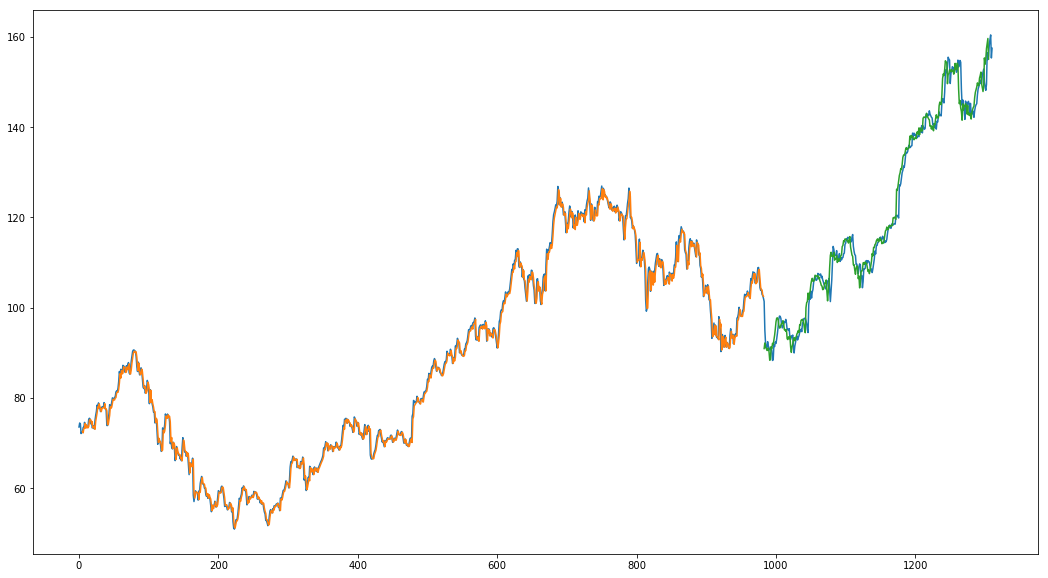

In [35]:
plt.plot(df_keras)
plt.plot(trainPred_shift)
plt.plot(testPred_shift)